[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juanhuguet/intro_to_nlp/blob/main/notebooks/06-text-clustering-with-embeddings.ipynb)

In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from datasets import load_dataset

In [4]:
import pandas as pd

### Load the dataset

In [5]:
dataset = load_dataset("yelp_review_full")

Found cached dataset yelp_review_full (/Users/jhuguet/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

### Convert it to pandas a random sample of 1000 articles

In [6]:
df = pd.DataFrame(dataset["train"].shuffle(42).select(range(1000)))

Loading cached shuffled indices for dataset at /Users/jhuguet/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-a0e621c27d9b360e.arrow


## Embedd sentences

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer("distiluse-base-multilingual-cased-v2", device="mps")

In [9]:
sentence_embedding = model.encode("This is a sentence about cats")

In [10]:
sentence_embedding.shape

(512,)

## Get sentence embeddings for all texts

In [11]:
from tqdm import tqdm
tqdm.pandas()

In [12]:
df["embedding"] = df["text"].progress_apply(model.encode)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.96it/s]


## Let's reduce the dimensionality and visualize the data in 2d

In [13]:
import umap

In [14]:
def reduce_dimensions(embeddings,
                      n_components=2,
                      n_neighbors=8,
                      random_state = 42):
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine',
                                 n_epochs=1000,
                                random_state=random_state)
                            .fit_transform(embeddings))
    df = pd.DataFrame(umap_embeddings, index=embeddings.index)
    return df

In [15]:
embeddings = df["embedding"].apply(pd.Series)

In [16]:
embeddings_2d = reduce_dimensions(embeddings)

In [17]:
embeddings_2d

,0,1
0,1.486349,11.070571
1,4.865225,11.754121
2,4.181653,9.198399
3,5.611241,13.356217
4,4.000916,15.358799
...,...,...
995,2.308882,12.618808
996,1.156935,10.366224
997,1.292375,13.610564
998,-0.054251,12.226327


### Let's visualize them...

In [18]:
import seaborn as sns

<Axes: xlabel='0', ylabel='1'>

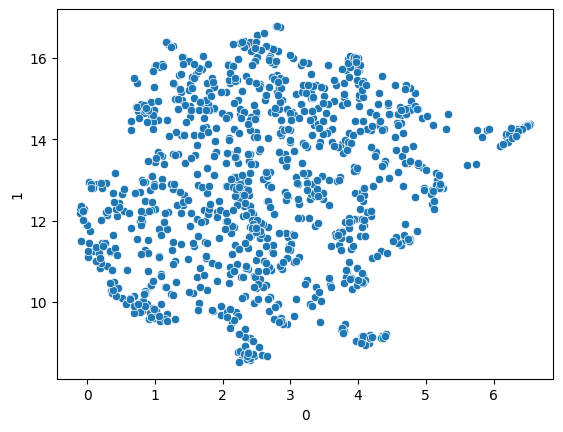

In [19]:
sns.scatterplot(embeddings_2d, x=0, y=1)

Nice, let's see if we can cluster them....

In [20]:
from sklearn.cluster import AgglomerativeClustering

In [21]:
clst = AgglomerativeClustering(n_clusters=10)

In [22]:
clusters = clst.fit_predict(embeddings)

## Let's assign the clusters to the visualization

<Axes: xlabel='0', ylabel='1'>

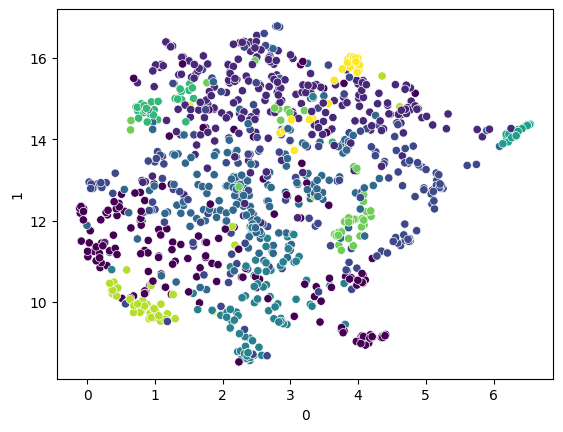

In [23]:
sns.scatterplot(embeddings_2d, x=0, y=1, c=clusters)

## Now, let's review the contents of the clusters...

In [24]:
df["cluster"] = clusters

In [25]:
df.sort_values(by="cluster")

,label,text,embedding,cluster
0,4,I stalk this truck. I've been to industrial p...,"[-0.064660594, 0.028532814, 0.023364328, -0.00...",0
241,3,I go out of my way to find a Fry's. Great cust...,"[0.049941562, 0.0074082823, 0.008650517, 0.018...",0
489,3,One of my new favourite shawarma places (and p...,"[0.008342066, -0.015408907, 0.027177617, -0.01...",0
246,1,Another new name but the same overpriced stuff...,"[0.005188524, 0.03574602, 0.02253216, -0.04269...",0
748,1,"I don't do dollar stores often, but I thought ...","[0.029022574, 0.04669227, 0.032092385, -0.0173...",0
...,...,...,...,...
310,1,"My wife absolutely loved her turkey burger, an...","[-0.015072733, 0.032361407, 0.015343991, 0.017...",9
769,4,The burger was excellent. Ordered to go at the...,"[-0.027631082, -0.020660583, 0.052475426, -0.0...",9
287,1,I guess I really just dont like buffets in thi...,"[-0.005341448, 0.0771184, 0.017128816, 0.00667...",9
76,0,Seemingly popular with the 20-somethings with ...,"[-0.005578079, 0.0068209805, 0.004916339, -0.0...",9


In [26]:
df.loc[df["cluster"] == 9, "text"]

24     Food was disappointing and ridiculously overpr...
54     The side of sauteed Spinach was incredibly sal...
76     Seemingly popular with the 20-somethings with ...
143    It wasn't horrible and it wasn't mind-blowing....
176    I though it was overpriced, the steak was good...
235    I like a menu that has limited choices. Howeve...
272    One of the best if not the best ever Bone In R...
287    I guess I really just dont like buffets in thi...
288    It's OK, I'm not going to go out of my way rav...
310    My wife absolutely loved her turkey burger, an...
390    A little overpriced for the quality. The filet...
419    We stopped for dinner want to have a steak.  T...
444    I first heard about this place when I saw Hube...
463    I thought the steak needed more flavor.   It w...
486    This is a great old steakhouse.  The steak was...
520    This place is awesome. Tasty burgers and fresh...
586    Just as the title implies the burgers are flam...
665    So I decided to bring a 